##Librarires

In [ ]:
import os
import glob
import numpy as np
from tqdm import tqdm
import itertools
import matplotlib.pyplot as plt
import pandas as pd

# Audio
import librosa
import librosa.display

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.utils import class_weight

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Drive Mount for reading data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/code"
# /content/gdrive/My Drive/Kaggle is the path where kaggle.json is present in the Google Drive

## Dataset dowload from kaggle to google drive

In [ ]:
#changing the working directory
# %cd /content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/code
#Check the present working directory using pwd command

In [ ]:
# !kaggle datasets download -d kinguistics/heartbeat-sounds

In [ ]:
#unzipping the zip files and deleting the zip files
# !unzip \*.zip  && rm *.zip

In [ ]:
# parent folder of sound files
INPUT_DIR="/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/code"

##Dataset Reading

In [ ]:
set_a=pd.read_csv(INPUT_DIR+"/set_a.csv")
set_a.head()

dataset                             fname     label  sublabel
0       a  set_a/artifact__201012172012.wav  artifact       NaN
1       a  set_a/artifact__201105040918.wav  artifact       NaN
2       a  set_a/artifact__201105041959.wav  artifact       NaN
3       a  set_a/artifact__201105051017.wav  artifact       NaN
4       a  set_a/artifact__201105060108.wav  artifact       NaN

In [ ]:
set_a.tail()

dataset                     fname label  sublabel
171       a  set_a/__201108222241.wav   NaN       NaN
172       a  set_a/__201108222244.wav   NaN       NaN
173       a  set_a/__201108222247.wav   NaN       NaN
174       a  set_a/__201108222254.wav   NaN       NaN
175       a  set_a/__201108222257.wav   NaN       NaN

##Data visualization

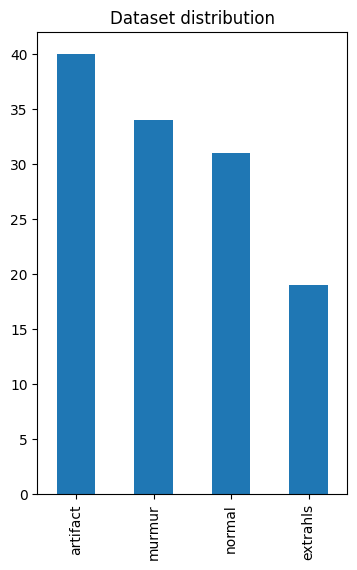

In [ ]:
plt.figure(figsize=(4,6))
set_a.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [ ]:
set_b=pd.read_csv(INPUT_DIR+"/set_b.csv")
set_b.head()

dataset                                              fname       label  \
0       b  set_b/Btraining_extrastole_127_1306764300147_C...  extrastole   
1       b  set_b/Btraining_extrastole_128_1306344005749_A...  extrastole   
2       b  set_b/Btraining_extrastole_130_1306347376079_D...  extrastole   
3       b  set_b/Btraining_extrastole_134_1306428161797_C...  extrastole   
4       b  set_b/Btraining_extrastole_138_1306762146980_B...  extrastole   

  sublabel  
0      NaN  
1      NaN  
2      NaN  
3      NaN  
4      NaN

In [ ]:
set_b.tail()

dataset                                              fname   label  \
651       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
652       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
653       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
654       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   
655       b  set_b/Btraining_normal_Btraining_noisynormal_2...  normal   

        sublabel  
651  noisynormal  
652  noisynormal  
653  noisynormal  
654  noisynormal  
655  noisynormal

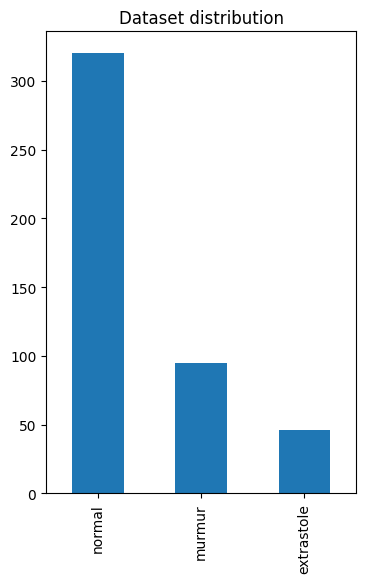

In [ ]:
plt.figure(figsize=(4,6))
set_b.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [ ]:
#merge both set-a and set-b
frames = [set_a, set_b]
complete=pd.concat(frames)
complete.describe()

dataset                             fname   label     sublabel
count      832                               832     585          149
unique       2                               832       5            2
top          b  set_a/artifact__201012172012.wav  normal  noisynormal
freq       656                                 1     351          120

In [ ]:
#get all unique labels
nb_classes=complete.label.unique()

print("Number of training examples=", complete.shape[0], "  Number of classes=", len(complete.label.unique()))
print (nb_classes)

Number of training examples= 832   Number of classes= 6
['artifact' 'extrahls' 'murmur' 'normal' nan 'extrastole']


1. Normal case
In the Normal category there are normal, healthy heart sounds. These may contain noise in the final second of the recording as the device is removed from the body. They may contain a variety of background noises (from traffic to radios). They may also contain occasional random noise corresponding to breathing, or brushing the microphone against clothing or skin. A normal heart sound has a clear “lub dub, lub dub” pattern, with the time from “lub” to “dub” shorter than the time from “dub” to the next “lub” (when the heart rate is less than 140 beats per minute)(source: Rita Getz)

In [ ]:
normal_file=INPUT_DIR+"/set_a/normal__201106111136.wav"

In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(normal_file)

In [ ]:
# Load use wave
import wave
wav = wave.open(normal_file)
print("Sampling (frame) rate = ", wav.getframerate())
print("Total samples (frames) = ", wav.getnframes())
print("Duration = ", wav.getnframes()/wav.getframerate())

Sampling (frame) rate =  44100
Total samples (frames) =  218903
Duration =  4.963786848072562


In [ ]:
# Load use scipy
from scipy.io import wavfile
rate, data = wavfile.read(normal_file)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
print(data)

Sampling (frame) rate =  44100
Total samples (frames) =  (218903,)
[-22835 -22726 -22595 ...   -474   -450   -439]


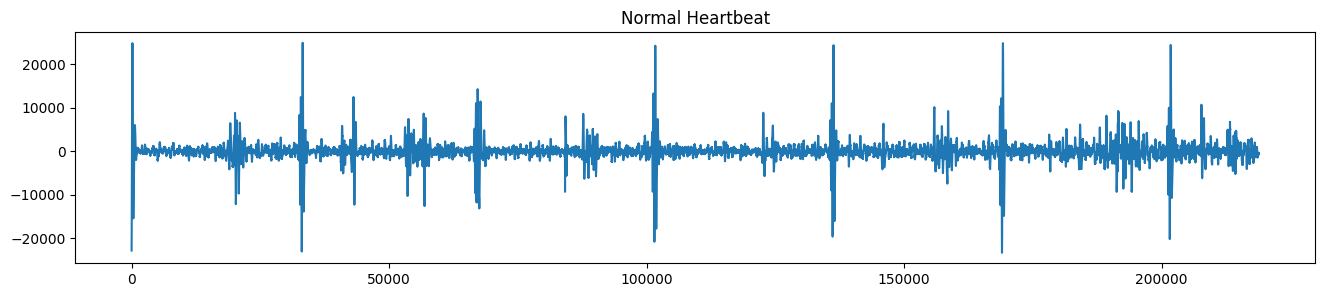

In [ ]:
# plot wave by audio frames
plt.figure(figsize=(16, 3))
plt.title("Normal Heartbeat")
plt.plot(data, '-', );

In [ ]:
# Here's a sample generate mfccs from a wave file
#y, sr = librosa.load(sample_file, offset=7, duration=7)
y, sr = librosa.load(normal_file)
mfccs = librosa.feature.mfcc(y=y, sr=sr)
print (mfccs)

[[-8.1913383e+01 -1.4807562e+02 -4.0729141e+02 ... -3.6786765e+02
  -3.7412061e+02 -3.7847031e+02]
 [ 1.2379559e+02  1.2622456e+02  1.3922583e+02 ...  1.5123857e+02
   1.6177921e+02  1.6117076e+02]
 [ 1.7456495e+01  1.9744457e+01  1.9956841e+01 ...  2.9298080e+01
   2.5672846e+01  3.3723259e+01]
 ...
 [-7.1166384e-01 -1.5279453e-01 -1.3570647e+00 ... -2.9591060e-01
   3.5141671e-01  2.2013929e+00]
 [-2.7901707e+00 -2.1342318e+00  4.8861966e-02 ...  2.5581970e+00
   3.4835339e-03  5.4476862e+00]
 [-1.3884711e-01  3.3570042e-01 -2.9419866e+00 ...  2.3936727e+00
  -1.4753814e+00  3.3484787e-01]]


In [ ]:
# Use a pre-computed log-power Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128,fmax=8000)
log_S=librosa.feature.mfcc(S=librosa.power_to_db(S))
print (log_S)

[[-6.1982685e+01 -1.2800838e+02 -3.9028296e+02 ... -3.5058395e+02
  -3.5407178e+02 -3.5892279e+02]
 [ 1.1376017e+02  1.1646744e+02  1.3576585e+02 ...  1.4986197e+02
   1.5767871e+02  1.5809064e+02]
 [ 2.1968611e+01  2.4365150e+01  1.1875892e+01 ...  2.0178368e+01
   1.8738571e+01  2.7622368e+01]
 ...
 [-1.3763463e+00 -7.9267335e-01 -2.0632410e+00 ...  2.9104097e+00
  -1.4185054e+00  1.5542814e+00]
 [-2.6494303e+00 -2.2966695e+00 -3.4821906e+00 ...  1.3711292e+00
   3.4655154e-02 -1.5800265e+00]
 [-4.1403542e+00 -4.1632433e+00 -1.6855962e+00 ...  4.1955769e-01
   6.4381516e-01 -3.5052805e+00]]


In [ ]:
# Get more components
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
#print (mfccs)

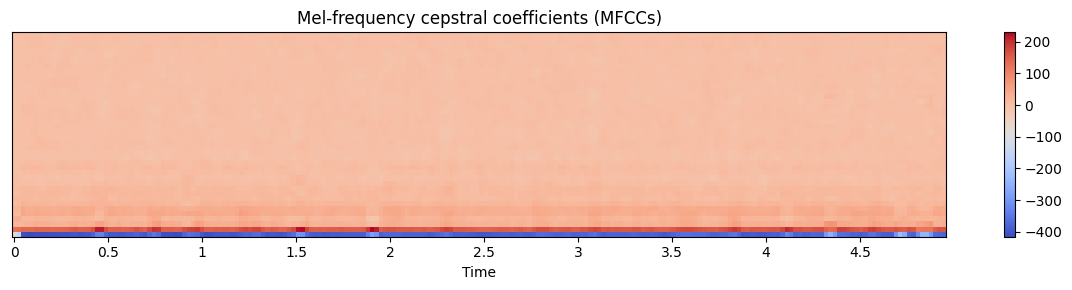

In [ ]:
# Visualize the MFCC series
# Mel-frequency cepstral coefficients (MFCCs)
plt.figure(figsize=(12, 3))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('Mel-frequency cepstral coefficients (MFCCs)')
plt.tight_layout()

In [ ]:
# Get onset times from a signal
onset_frames = librosa.onset.onset_detect(y=y, sr=sr)
librosa.frames_to_time(onset_frames, sr=sr)

array([0.48761905, 0.7662585 , 0.95201814, 1.25387755, 1.55573696,
       1.92725624, 2.32199546, 2.80961451, 3.11147392, 3.80807256,
       3.85451247, 4.13315193, 4.36535147, 4.59755102, 4.73687075,
       4.85297052])

2. Murmur
Heart murmurs sound as though there is a “whooshing, roaring, rumbling, or turbulent fluid” noise in one of two temporal locations: (1) between “lub” and “dub”, or (2) between “dub” and “lub”. They can be a symptom of many heart disorders, some serious. There will still be a “lub” and a “dub”. One of the things that confuses non-medically trained people is that murmurs happen between lub and dub or between dub and lub; not on lub and not on dub.(source: Rita Getz)

In [ ]:
# murmur case
murmur_file=INPUT_DIR+"/set_a/murmur__201108222231.wav"
y2, sr2 = librosa.load(murmur_file)
print(y2.shape,sr2)

(174979,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(murmur_file)

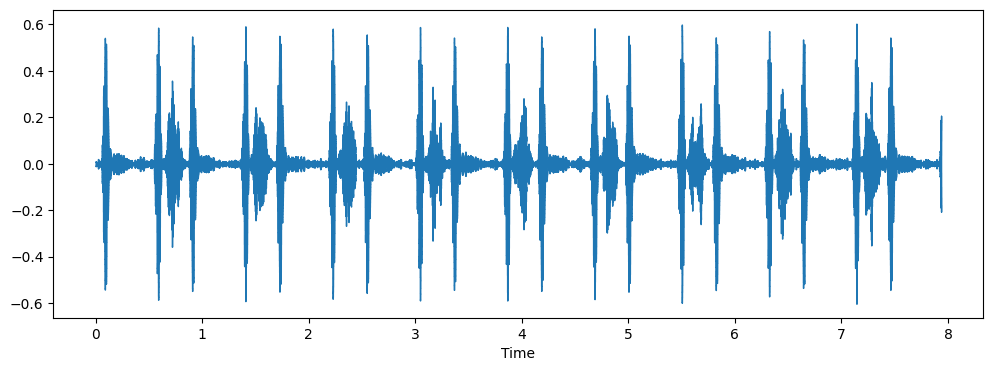

In [ ]:
import librosa.display
plt.figure(figsize=(12, 4))
librosa.display.waveshow(y2, sr=sr2)

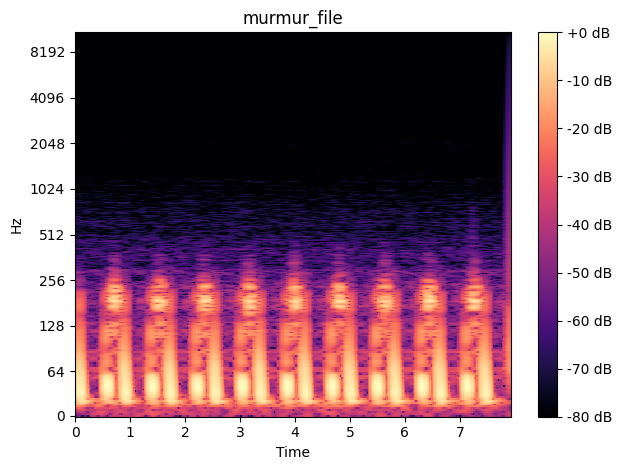

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(murmur_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('murmur_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

3. Extrasystole


Extrasystole sounds may appear occasionally and can be identified because there is a heart sound that is out of rhythm involving extra or skipped heartbeats, e.g. a “lub-lub dub” or a “lub dub-dub”. (This is not the same as an extra heart sound as the event is not regularly occuring.) An extrasystole may not be a sign of disease. It can happen normally in an adult and can be very common in children. However, in some situations extrasystoles can be caused by heart diseases. If these diseases are detected earlier, then treatment is likely to be more effective. (source: Rita Getz)

In [ ]:
# Extrasystole case
extrastole_file=INPUT_DIR+"/set_b/extrastole__127_1306764300147_C2.wav"
y3, sr3 = librosa.load(extrastole_file)
print(y3.shape,sr3)

(103106,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(extrastole_file)

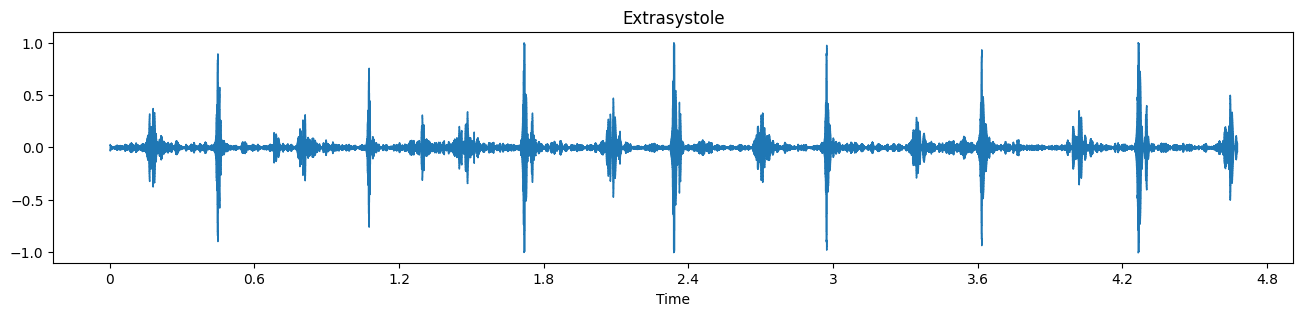

In [ ]:
# show it
plt.figure(figsize=(16, 3))
plt.title("Extrasystole")
librosa.display.waveshow(y3, sr=sr3)

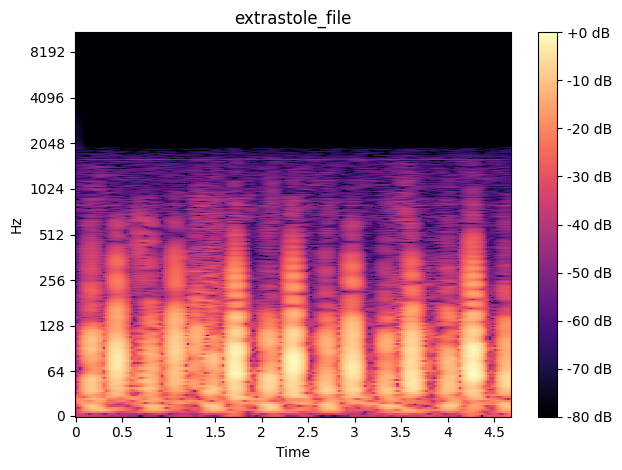

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(extrastole_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('extrastole_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

4. Artifact
In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [ ]:
# sample file
artifact_file=INPUT_DIR+"/set_a/artifact__201012172012.wav"
y4, sr4 = librosa.load(artifact_file)
print(y4.shape,sr4)

(198450,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(artifact_file)

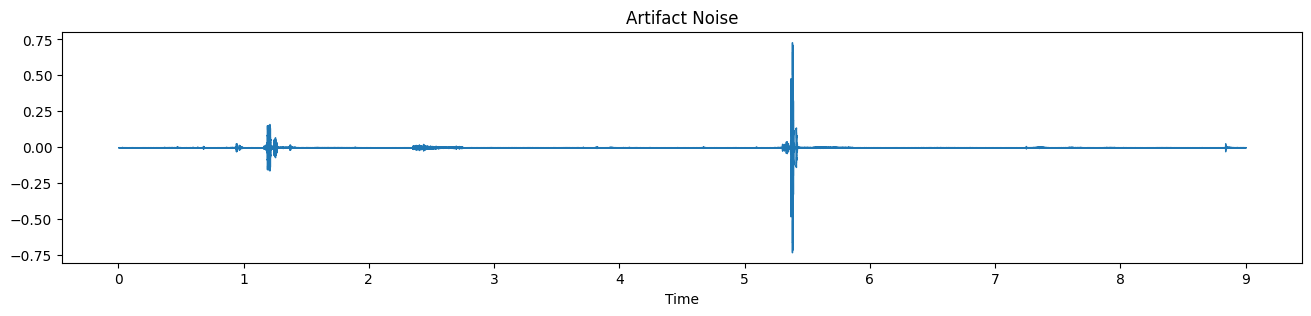

In [ ]:
# show it
plt.figure(figsize=(16, 3))
plt.title("Artifact Noise")
librosa.display.waveshow(y4, sr=sr4)

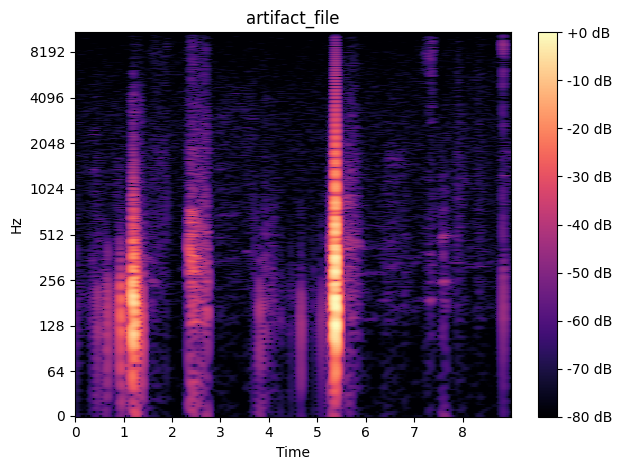

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(artifact_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('artifact_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

5. Extra Heart Sound


In the Artifact category there are a wide range of different sounds, including feedback squeals and echoes, speech, music and noise. There are usually no discernable heart sounds, and thus little or no temporal periodicity at frequencies below 195 Hz. This category is the most different from the others. It is important to be able to distinguish this category from the other three categories, so that someone gathering the data can be instructed to try again.(source: Rita Getz)

In [ ]:
# sample file
extrahls_file=INPUT_DIR+"/set_a/extrahls__201101070953.wav"
y5, sr5 = librosa.load(extrahls_file)
print(y5.shape,sr5)

(195894,) 22050


In [ ]:
# heart it
import IPython.display as ipd
ipd.Audio(extrahls_file)

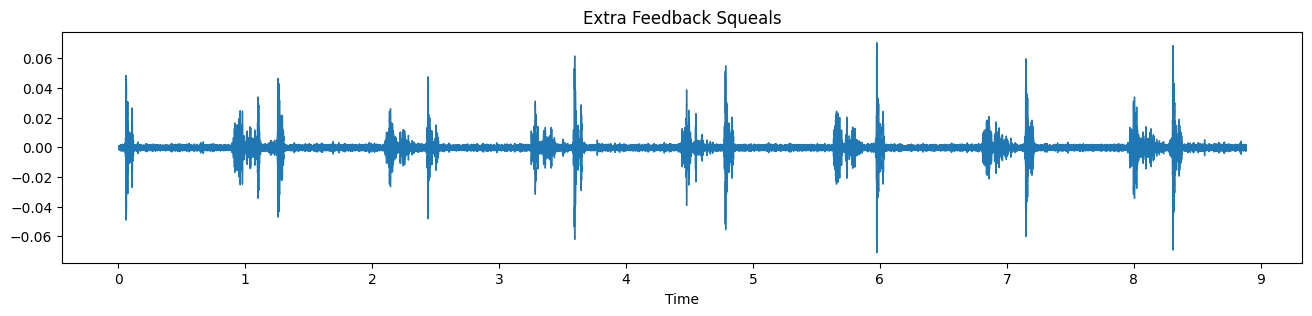

In [ ]:
# show it
plt.figure(figsize=(16, 3))
plt.title("Extra Feedback Squeals")
librosa.display.waveshow(y5, sr=sr5)

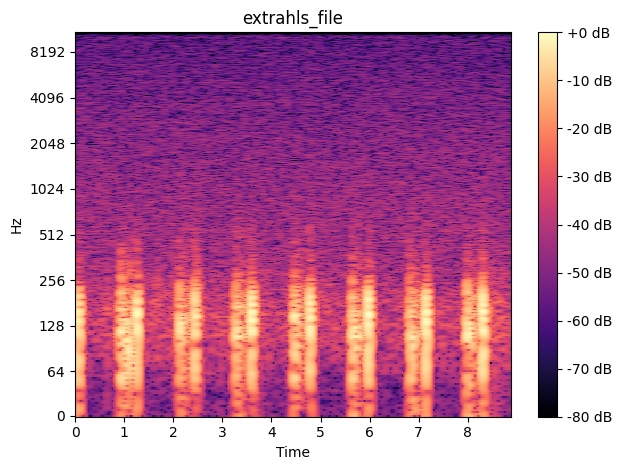

In [ ]:
# getting information from the file
time_series, sample_rate = librosa.load(extrahls_file)# getting a matrix which contains amplitude values according to frequency and time indexes
stft = np.abs(librosa.stft(time_series, hop_length=512, n_fft=2048*4))# converting the matrix to decibel matrix
spectrogram = librosa.amplitude_to_db(stft, ref=np.max)
librosa.display.specshow(spectrogram, y_axis='log', x_axis='time')
plt.title('extrahls_file')
plt.colorbar(format='%+2.0f dB')
plt.tight_layout()
plt.show()

In [ ]:

bird_sample_list = ['normal', 'murmur', 'extrastole', 'artifact', 'extraheatsound'  ]

# Importing the 5 files
y_amered, sr_amered = librosa.load(normal_file)
audio_amered, _ = librosa.effects.trim(y_amered)

y_cangoo, sr_cangoo = librosa.load(murmur_file)
audio_cangoo, _ = librosa.effects.trim(y_cangoo)

y_haiwoo, sr_haiwoo = librosa.load(extrastole_file)
audio_haiwoo, _ = librosa.effects.trim(y_haiwoo)

y_pingro, sr_pingro = librosa.load(artifact_file)
audio_pingro, _ = librosa.effects.trim(y_pingro)

y_vesspa, sr_vesspa = librosa.load(extrahls_file)
audio_vesspa, _ = librosa.effects.trim(y_vesspa)




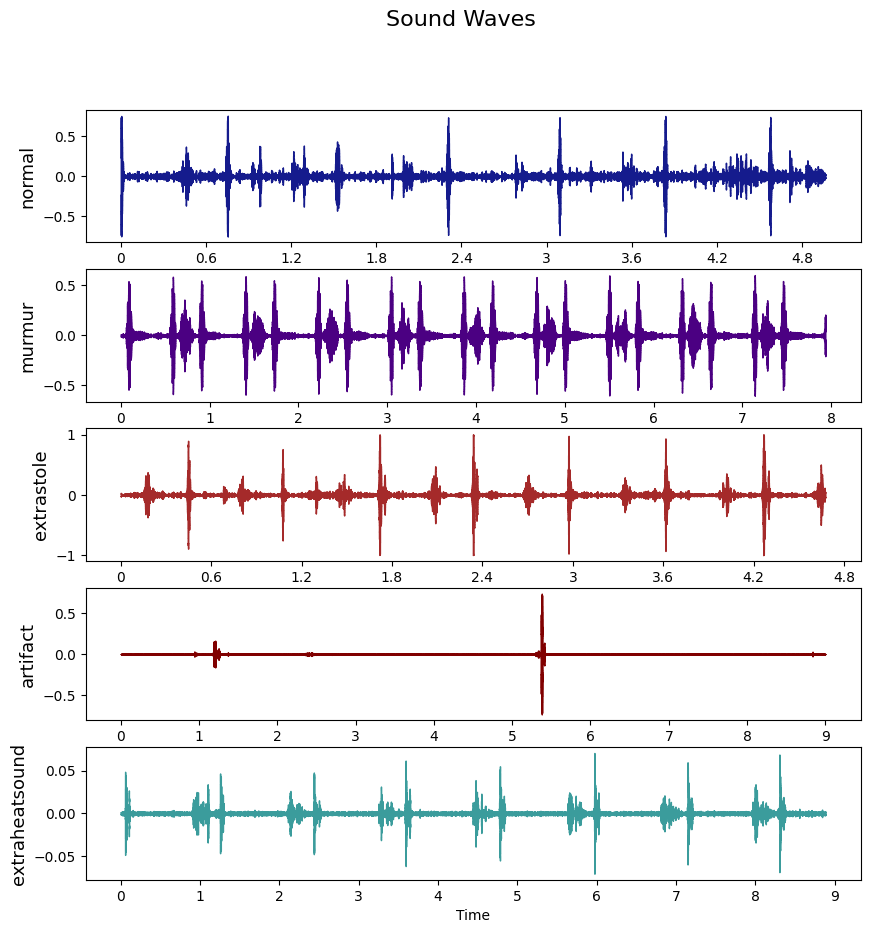

In [ ]:
fig, ax = plt.subplots(5, figsize = (10, 10))
fig.suptitle('Sound Waves', fontsize=16)

librosa.display.waveshow(y = audio_amered, sr = sr, color = "#151B8D", ax=ax[0])
librosa.display.waveshow(y = audio_cangoo, sr = sr, color = "#4B0082", ax=ax[1])
librosa.display.waveshow(y = audio_haiwoo, sr = sr, color = "#A52A2A", ax=ax[2])
librosa.display.waveshow(y = audio_pingro, sr = sr, color = "#800000", ax=ax[3])
librosa.display.waveshow(y = audio_vesspa, sr = sr, color = "#3B9C9C", ax=ax[4])


for i, name in zip(range(5), bird_sample_list):
    ax[i].set_ylabel(name, fontsize=13)

In [ ]:
dataset = []
for folder in ["/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/code/set_a/**","/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/code/set_b/**"]:
    for filename in glob.iglob(folder):
        if os.path.exists(filename):
            label = os.path.basename(filename).split("_")[0]
            duration = librosa.get_duration(filename=filename)
            # skip audio smaller than 3 secs
            if duration>=3:
                slice_size = 3
                iterations = int((duration-slice_size)/(slice_size-1))
                iterations += 1
#                 initial_offset = (duration % slice_size)/2
                initial_offset = (duration - ((iterations*(slice_size-1))+1))/2
                if label not in ["Aunlabelledtest", "Bunlabelledtest"]:
                    for i in range(iterations):
                        offset = initial_offset + i*(slice_size-1)

                        dataset.append({
                                "filename": filename,
                                "label": label,
                                "offset": offset
                            })


dataset = pd.DataFrame(dataset)
dataset = shuffle(dataset, random_state=42)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1441 entries, 168 to 1126
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   filename  1441 non-null   object 
 1   label     1441 non-null   object 
 2   offset    1441 non-null   float64
dtypes: float64(1), object(2)
memory usage: 45.0+ KB


In [ ]:
music="/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/code/set_a/"
import librosa
import IPython.display as ipd
x,sr=librosa.load(music+"normal__201106221418.wav")
ipd.Audio(x,rate=sr)

In [ ]:
dataset.head()

filename     label    offset
168   /content/drive/MyDrive/july2023/Ahmed_sagheer_...  artifact  2.000000
1001  /content/drive/MyDrive/july2023/Ahmed_sagheer_...    normal  4.298250
549   /content/drive/MyDrive/july2023/Ahmed_sagheer_...    murmur  6.417375
65    /content/drive/MyDrive/july2023/Ahmed_sagheer_...  artifact  2.000000
629   /content/drive/MyDrive/july2023/Ahmed_sagheer_...    normal  0.344625

In [ ]:
dataset.tail()

filename       label    offset
1095  /content/drive/MyDrive/july2023/Ahmed_sagheer_...      normal  2.060125
1130  /content/drive/MyDrive/july2023/Ahmed_sagheer_...      normal  4.451250
1294  /content/drive/MyDrive/july2023/Ahmed_sagheer_...      normal  2.832625
860   /content/drive/MyDrive/july2023/Ahmed_sagheer_...      murmur  2.286625
1126  /content/drive/MyDrive/july2023/Ahmed_sagheer_...  extrastole  2.523000

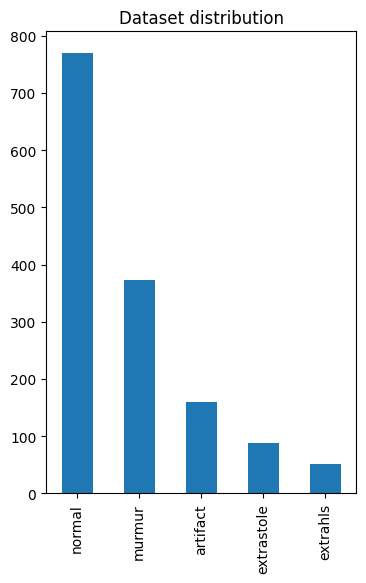

In [ ]:
plt.figure(figsize=(4,6))
dataset.label.value_counts().plot(kind='bar', title="Dataset distribution")
plt.show()

In [ ]:
def add_noise(data):
    noise_value = 0.015 * np.random.uniform() * np.amax(data)
    data = data + noise_value * np.random.normal(size=data.shape[0])

    return data

**Machine Leaning**

In [ ]:
SAMPLE_RATE = 44100
# Generate mfcc features with mean and standard deviation
from scipy.stats import skew
def extract_process(data):
    output_result = np.array([])
    ft1 = librosa.feature.mfcc(y=data, sr = SAMPLE_RATE, n_mfcc=40)
    ft2 = librosa.feature.zero_crossing_rate(y=data)[0]
    ft3 = librosa.feature.spectral_rolloff(y=data)[0]
    ft4 = librosa.feature.spectral_centroid(y=data)[0]
    ft5 = librosa.feature.spectral_contrast(y=data)[0]
    ft6 = librosa.feature.spectral_bandwidth(y=data)[0]
    stft_out = np.abs(librosa.stft(data))
    ft7 = librosa.feature.chroma_stft(S=stft_out, sr=SAMPLE_RATE)[0]
    ft8 = librosa.feature.rms(y=data)[0]
    ft9 = librosa.feature.melspectrogram(y=data)[0]
    ft1_trunc = np.hstack((np.mean(ft1, axis=1), np.std(ft1, axis=1), skew(ft1, axis = 1), np.max(ft1, axis = 1), np.median(ft1, axis = 1), np.min(ft1, axis = 1)))
    ft2_trunc = np.hstack((np.mean(ft2), np.std(ft2), skew(ft2), np.max(ft2), np.median(ft2), np.min(ft2)))
    ft3_trunc = np.hstack((np.mean(ft3), np.std(ft3), skew(ft3), np.max(ft3), np.median(ft3), np.min(ft3)))
    ft4_trunc = np.hstack((np.mean(ft4), np.std(ft4), skew(ft4), np.max(ft4), np.median(ft4), np.min(ft4)))
    ft5_trunc = np.hstack((np.mean(ft5), np.std(ft5), skew(ft5), np.max(ft5), np.median(ft5), np.min(ft5)))
    ft6_trunc = np.hstack((np.mean(ft6), np.std(ft6), skew(ft6), np.max(ft6), np.median(ft6), np.max(ft6)))
    ft7_trunc = np.hstack((np.mean(ft7), np.std(ft7), skew(ft7), np.max(ft7), np.median(ft7), np.max(ft7)))
    ft8_trunc = np.hstack((np.mean(ft8), np.std(ft8), skew(ft8), np.max(ft8), np.median(ft8), np.max(ft8)))
    ft9_trunc = np.hstack((np.mean(ft9), np.std(ft9), skew(ft9), np.max(ft9), np.median(ft9), np.max(ft9)))
    output_result = np.hstack((ft1_trunc, ft2_trunc, ft3_trunc, ft4_trunc, ft5_trunc, ft6_trunc, ft7_trunc, ft8_trunc, ft9_trunc))
    return output_result


In [ ]:
def export_process(path):

    data,sample_rate = librosa.load(path)

    output_1 = extract_process(data)
    result = np.array(output_1)

    noise_out = add_noise(data)
    output_2 = extract_process(noise_out)
    result = np.vstack((result,output_2))

#     new_out = stretch_process(data)
#     strectch_pitch = pitch_process(new_out,sample_rate)
#     output_3 = extract_process(strectch_pitch)
#     result = np.vstack((result,output_3))

    return result

In [ ]:
dataset.head()

filename     label    offset
168   /content/drive/MyDrive/july2023/Ahmed_sagheer_...  artifact  2.000000
1001  /content/drive/MyDrive/july2023/Ahmed_sagheer_...    normal  4.298250
549   /content/drive/MyDrive/july2023/Ahmed_sagheer_...    murmur  6.417375
65    /content/drive/MyDrive/july2023/Ahmed_sagheer_...  artifact  2.000000
629   /content/drive/MyDrive/july2023/Ahmed_sagheer_...    normal  0.344625

In [ ]:
%time
x_Train, y_Train = [],[]

for path,emotion in zip(dataset.filename,dataset.label):

    features = export_process(path)

    for element in features:
        x_Train.append(element)
        y_Train.append(emotion)

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs


In [ ]:
print(len(x_Train))
print(len(y_Train))
print(len(dataset.filename))

2882
2882
1441


In [ ]:
# New_Features_Wav = pd.DataFrame(x_Train)
# New_Features_Wav["labels"] = y_Train

# New_Features_Wav.to_csv("/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/New_heart_sound_gpu_Add_noise.csv",index=False)

In [ ]:
New_Features_Wav = pd.read_csv('/content/drive/MyDrive/july2023/Ahmed_sagheer_heart_sound/New_heart_sound_gpu_Add_noise.csv')

In [ ]:
New_Features_Wav.head(-1)

0           1          2          3          4          5  \
0    -300.498596  170.725693   4.420231 -51.190884 -46.566708 -47.785107   
1    -253.668125  128.224296  14.778274 -42.047169 -50.630576 -49.207780   
2    -371.834930  201.501007  31.911694 -17.021698  20.104042  23.630356   
3    -322.138686  151.598329  41.797790  -3.919424  11.585768  18.790047   
4    -342.590027  206.465958   7.074973 -27.012802  33.251553  28.182850   
...          ...         ...        ...        ...        ...        ...   
2876 -388.930298  189.659958  38.307541  -5.777030  25.286497  24.087523   
2877 -297.954108  104.575091  48.585186  16.531839  14.610702  14.931365   
2878 -448.123230  203.618073  14.298789 -11.296372  47.022327  31.521362   
2879 -296.227982   64.460877  36.579344  22.089342  21.639523  17.325538   
2880 -308.957428  203.497772  41.950596 -10.795247  23.245424  30.410894   

              6          7          8         9  ...       279       280  \
0    -49.855812 -29.603300 -11.662650 -8.498637  ...  0.507814  0.468632   
1    -44.847526 -29.076101 -13.925328 -6.814999  ...  0.507860  0.468561   
2      0.120465   2.189532   8.329476 -3.873977  ...  0.202991  0.025044   
3      7.416337   2.808816   2.762377 -1.993618  ...  0.203018  0.025068   
4     -6.970482   6.626155  22.195559  0.938690  ...  0.247303  0.030573   
...         ...        ...        ...       ...  ...       ...       ...   
2876   0.190693   5.949948  17.235935  3.479146  ...  0.159353  0.027737   
2877  10.264350   8.613810   8.570758  4.547086  ...  0.159347  0.027923   
2878 -10.869866   4.044826  23.239197  2.465430  ...  0.075395  0.018479   
2879   9.313505   7.424684   8.822158  6.155893  ...  0.075496  0.019103   
2880   4.518812  -0.797497   7.937642  3.451611  ...  0.396882  0.100909   

           281         282         283        284          285        286  \
0     0.507814    0.011055    0.034270  13.058542     0.589709   0.004239   
1     0.507860    0.011881    0.033916  13.068598     0.585211   0.005040   
2     0.202991    9.505301   14.238291   2.179377    88.781013   2.905814   
3     0.203018    9.503410   14.232664   2.178000    88.761163   2.901940   
4     0.247303   21.538811   40.836002   3.157938   292.426178   4.031093   
...        ...         ...         ...        ...          ...        ...   
2876  0.159353   32.515034   73.289322   3.587833   585.703735   4.592827   
2877  0.159347   32.515492   73.283487   3.586883   585.528868   4.627256   
2878  0.075395   11.086469   19.084509   3.250198   130.623734   3.028625   
2879  0.075496   11.081991   19.069260   3.255644   130.976402   3.085692   
2880  0.396882  148.885040  272.885803   2.303797  1334.627563  16.113760   

              287      labels  
0        0.589709    artifact  
1        0.585211    artifact  
2       88.781013      normal  
3       88.761163      normal  
4      292.426178      murmur  
...           ...         ...  
2876   585.703735      normal  
2877   585.528868      normal  
2878   130.623734      murmur  
2879   130.976402      murmur  
2880  1334.627563  extrastole  

[2881 rows x 289 columns]

In [ ]:
New_Features_Wav.tail()

0           1          2          3          4          5  \
2877 -297.954108  104.575091  48.585186  16.531839  14.610702  14.931365   
2878 -448.123230  203.618073  14.298789 -11.296372  47.022327  31.521362   
2879 -296.227982   64.460877  36.579344  22.089342  21.639523  17.325538   
2880 -308.957428  203.497772  41.950596 -10.795247  23.245424  30.410894   
2881 -186.602165   95.238827  48.547893  17.678470  14.714622  17.041394   

              6         7          8         9  ...       279       280  \
2877  10.264350  8.613810   8.570758  4.547086  ...  0.159347  0.027923   
2878 -10.869866  4.044826  23.239197  2.465430  ...  0.075395  0.018479   
2879   9.313505  7.424684   8.822158  6.155893  ...  0.075496  0.019103   
2880   4.518812 -0.797497   7.937642  3.451611  ...  0.396882  0.100909   
2881  11.863931  4.617188   2.385402  3.030900  ...  0.397173  0.101647   

           281         282         283       284          285        286  \
2877  0.159347   32.515492   73.283487  3.586883   585.528868   4.627256   
2878  0.075395   11.086469   19.084509  3.250198   130.623734   3.028625   
2879  0.075496   11.081991   19.069260  3.255644   130.976402   3.085692   
2880  0.396882  148.885040  272.885803  2.303797  1334.627563  16.113760   
2881  0.397173  148.809328  272.701550  2.301428  1331.420170  15.766352   

              287      labels  
2877   585.528868      normal  
2878   130.623734      murmur  
2879   130.976402      murmur  
2880  1334.627563  extrastole  
2881  1331.420170  extrastole  

[5 rows x 289 columns]

In [ ]:
print(New_Features_Wav["labels"].value_counts())

normal        1538
murmur         746
artifact       320
extrastole     176
extrahls       102
Name: labels, dtype: int64


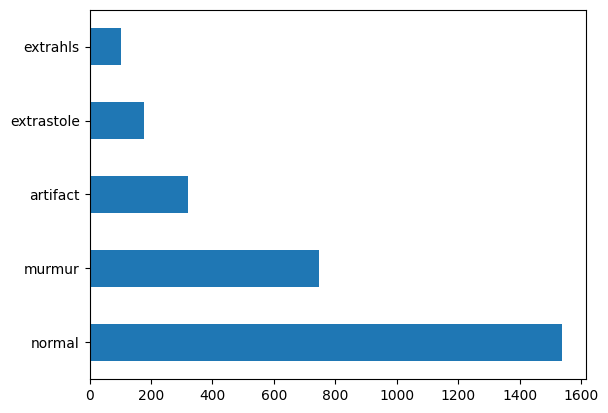

In [ ]:

%matplotlib inline

New_Features_Wav["labels"].value_counts().plot(kind='barh')
plt.savefig('events_count.pdf', dpi=1)

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
encoder_label = OneHotEncoder()

In [ ]:
scaler_data = StandardScaler()

In [ ]:
New_Features_Wav.head()

0           1          2          3          4          5  \
0 -300.498596  170.725693   4.420231 -51.190884 -46.566708 -47.785107   
1 -253.668125  128.224296  14.778274 -42.047169 -50.630576 -49.207780   
2 -371.834930  201.501007  31.911694 -17.021698  20.104042  23.630356   
3 -322.138686  151.598329  41.797790  -3.919424  11.585768  18.790047   
4 -342.590027  206.465958   7.074973 -27.012802  33.251553  28.182850   

           6          7          8         9  ...       279       280  \
0 -49.855812 -29.603300 -11.662650 -8.498637  ...  0.507814  0.468632   
1 -44.847526 -29.076101 -13.925328 -6.814999  ...  0.507860  0.468561   
2   0.120465   2.189532   8.329476 -3.873977  ...  0.202991  0.025044   
3   7.416337   2.808816   2.762377 -1.993618  ...  0.203018  0.025068   
4  -6.970482   6.626155  22.195559  0.938690  ...  0.247303  0.030573   

        281        282        283        284         285       286  \
0  0.507814   0.011055   0.034270  13.058542    0.589709  0.004239   
1  0.507860   0.011881   0.033916  13.068598    0.585211  0.005040   
2  0.202991   9.505301  14.238291   2.179377   88.781013  2.905814   
3  0.203018   9.503410  14.232664   2.178000   88.761163  2.901940   
4  0.247303  21.538811  40.836002   3.157938  292.426178  4.031093   

          287    labels  
0    0.589709  artifact  
1    0.585211  artifact  
2   88.781013    normal  
3   88.761163    normal  
4  292.426178    murmur  

[5 rows x 289 columns]

In [ ]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["labels"].values

In [ ]:
print(X.shape)
print(Y.shape)

(2882, 288)
(2882,)


In [ ]:
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
print(Y.shape)

(2882, 5)


In [ ]:
xTrain,xTest,yTrain,yTest = train_test_split(X,Y,train_size=0.8,random_state=42)

In [ ]:
print(xTrain.shape)
print(yTrain.shape)
print(xTest.shape)
print(yTest.shape)

(2305, 288)
(2305, 5)
(577, 288)
(577, 5)


In [ ]:
xTrain = scaler_data.fit_transform(xTrain)
xTest = scaler_data.transform(xTest)

In [ ]:
print(xTrain.shape)
print(xTest.shape)

(2305, 288)
(577, 288)


# 1. **Machine Leaning Models**

# RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest=RandomForestClassifier(max_depth= 8,
 max_features= 5,
 min_samples_split=5,
 n_estimators=500).fit(xTrain,yTrain)
forest

RandomForestClassifier(max_depth=8, max_features=5, min_samples_split=5,
                       n_estimators=500)

In [ ]:
from sklearn.metrics import accuracy_score
y_pred=forest.predict(xTest)
accuracy_score(yTest,y_pred)

0.8058925476603119

In [ ]:


predictions7 = forest.predict(xTest)
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(yTest, predictions7))
accuracyScore = accuracy_score(predictions7, yTest )
print("Accuracy score after train test split (RF): ", accuracyScore * 100.0)



              precision    recall  f1-score   support

           0       0.97      1.00      0.98        65
           1       1.00      0.54      0.70        28
           2       0.00      0.00      0.00        32
           3       1.00      0.56      0.72       142
           4       0.82      0.98      0.89       310

   micro avg       0.87      0.81      0.84       577
   macro avg       0.76      0.62      0.66       577
weighted avg       0.84      0.81      0.80       577
 samples avg       0.81      0.81      0.81       577

Accuracy score after train test split (RF):  80.58925476603119


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
nb_classes=New_Features_Wav["labels"].unique()

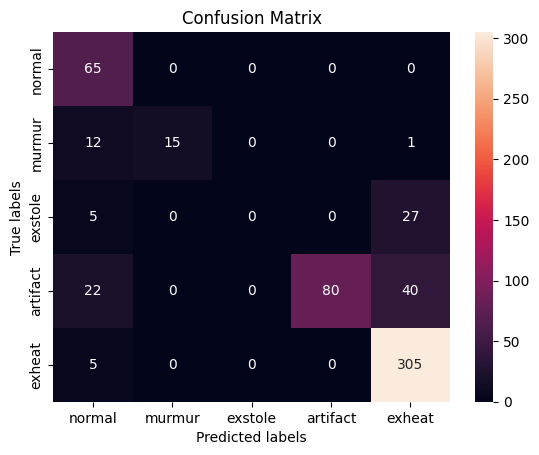

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictions7).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
mlp=MLPClassifier().fit(xTrain,yTrain)
mlp

MLPClassifier()

In [ ]:
y_pred_mlp=mlp.predict(xTest)
accuracy_score(yTest,y_pred_mlp)

0.9532062391681109

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(yTest, y_pred_mlp))
accuracyScore = accuracy_score(y_pred_mlp, yTest )
print("Accuracy score after train test split (MLP): ", accuracyScore * 100.0)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00        65
           1       1.00      1.00      1.00        28
           2       1.00      0.84      0.92        32
           3       0.98      0.94      0.96       142
           4       0.95      0.99      0.97       310

   micro avg       0.97      0.97      0.97       577
   macro avg       0.99      0.95      0.97       577
weighted avg       0.97      0.97      0.97       577
 samples avg       0.96      0.97      0.96       577

Accuracy score after train test split (MLP):  95.32062391681109


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


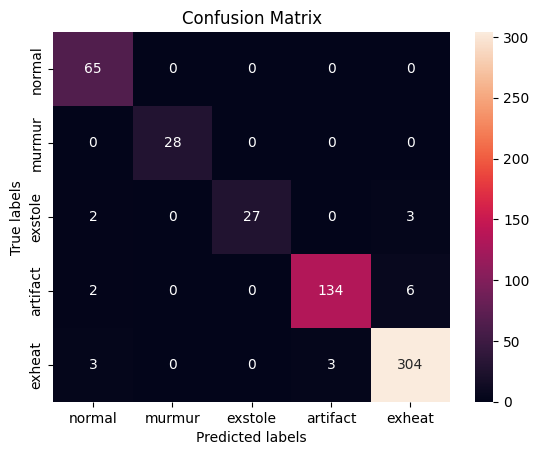

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(y_pred_mlp).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Optimal model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# Optimal model
knn = KNeighborsClassifier()




knn.fit(xTrain, yTrain)
predictionsknn=knn.predict(xTest)


from sklearn.metrics import classification_report
print(classification_report(yTest, predictionsknn))
accuracyScore = accuracy_score(predictionsknn, yTest )
print("Accuracy score after train test split (knn): ", accuracyScore * 100.0)


              precision    recall  f1-score   support

           0       0.98      0.95      0.97        65
           1       0.90      1.00      0.95        28
           2       0.68      0.41      0.51        32
           3       0.87      0.84      0.85       142
           4       0.91      0.91      0.91       310

   micro avg       0.90      0.88      0.89       577
   macro avg       0.87      0.82      0.84       577
weighted avg       0.90      0.88      0.88       577
 samples avg       0.88      0.88      0.88       577

Accuracy score after train test split (knn):  87.52166377816292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


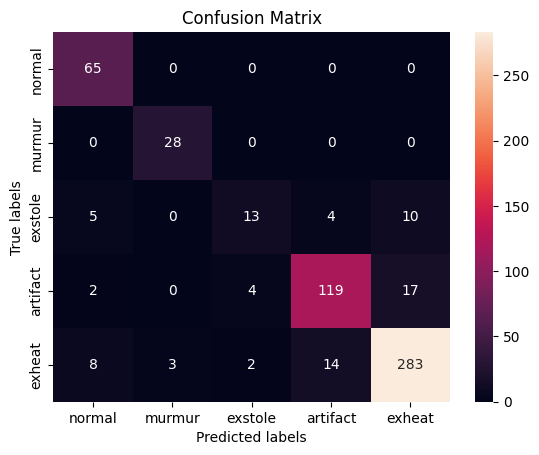

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictionsknn).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# DT

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Optimal model
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
# Optimal model
dt = DecisionTreeClassifier()




dt.fit(xTrain, yTrain)
predictionsdt=dt.predict(xTest)


from sklearn.metrics import classification_report
print(classification_report(yTest, predictionsdt))
accuracyScore = accuracy_score(predictionsdt, yTest )
print("Accuracy score after train test split (dt): ", accuracyScore * 100.0)


              precision    recall  f1-score   support

           0       0.94      0.97      0.95        65
           1       0.92      0.79      0.85        28
           2       0.75      0.56      0.64        32
           3       0.82      0.88      0.85       142
           4       0.90      0.90      0.90       310

   micro avg       0.88      0.88      0.88       577
   macro avg       0.87      0.82      0.84       577
weighted avg       0.88      0.88      0.88       577
 samples avg       0.88      0.88      0.88       577

Accuracy score after train test split (dt):  87.8682842287695


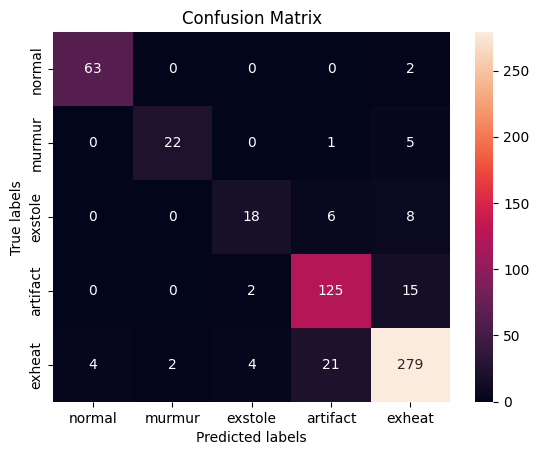

In [ ]:
import seaborn as sns

T5_lables = ['normal', 'murmur', 'exstole', 'artifact', 'exheat'  ]

ax= plt.subplot()

cm = confusion_matrix(np.asarray(yTest).argmax(axis=1), np.asarray(predictionsdt).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(T5_lables); ax.yaxis.set_ticklabels(T5_lables);

# Deep Leaning

In [ ]:
!pip install pydub

In [ ]:
#GENERAL
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
#PATH PROCESS
import os
import os.path
from pathlib import Path
import glob
#IMAGE PROCESS
from PIL import Image
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from keras.applications.vgg16 import preprocess_input, decode_predictions
import imageio
from IPython.display import Image
import matplotlib.image as mpimg
#MUSIC PROCESS
import pydub
from scipy.io.wavfile import read, write
import librosa
import librosa.display
import IPython
from IPython.display import Audio
import scipy
#SCALER & TRANSFORMATION
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras import regularizers
from sklearn.preprocessing import LabelEncoder
#ACCURACY CONTROL
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
#OPTIMIZER
# from keras.optimizers import Adam,Optimizer,Optimizer, SGD
from tensorflow.keras.optimizers import Adam,Optimizer,Optimizer, SGD
#MODEL LAYERS
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization,MaxPooling2D,BatchNormalization,\
                        Permute, TimeDistributed, Bidirectional,GRU, SimpleRNN,\
LSTM, GlobalAveragePooling2D, SeparableConv2D, ZeroPadding2D, Convolution2D, ZeroPadding2D,Reshape,\
Conv2DTranspose, LeakyReLU, Conv1D, AveragePooling1D, MaxPooling1D
from keras import models
from keras import layers
import tensorflow as tf
from tensorflow.keras.applications import VGG16,VGG19,inception_v3
from keras import backend as K
from tensorflow.keras.utils import plot_model
from tensorflow.keras.datasets import mnist
import keras
#SKLEARN CLASSIFIER
# from xgboost import XGBClassifier, XGBRegressor
# from lightgbm import LGBMClassifier, LGBMRegressor
# from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV
#IGNORING WARNINGS
from warnings import filterwarnings
filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning)
filterwarnings("ignore", category=UserWarning)

In [ ]:
print(xTrain.shape)
print(xTest.shape)

(2305, 288, 1)
(577, 288, 1)


In [ ]:

xTrain = np.expand_dims(xTrain,axis=2)
xTest = np.expand_dims(xTest,axis=2)

In [ ]:
print(xTrain.shape)
print(xTest.shape)

(2305, 288, 1, 1)
(577, 288, 1, 1)


In [ ]:
Model=Sequential()
Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(xTrain.shape[1], 1)))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
Model.add(Dropout(0.2))

Model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
Model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

Model.add(Flatten())
Model.add(Dense(units=32, activation='relu'))
Model.add(Dropout(0.3))

Model.add(Dense(units=5, activation='softmax'))

In [ ]:
Model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 288, 256)          1536      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 144, 256)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 144, 256)          327936    
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 72, 256)          0         
 1D)                                                             
                                                                 
 conv1d_2 (Conv1D)           (None, 72, 128)           163968    
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 36, 128)         

In [ ]:
Model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3,mode="min")

In [ ]:
Conv1D_Model = Model.fit(xTrain, yTrain, batch_size=64, epochs=90, validation_data=(xTest, yTest))
# Conv1D_Model = Model.fit(xTrain, yTrain, batch_size=64, epochs=90, validation_split=0.2)

Epoch 1/90
37/37 [==============================] - 30s 91ms/step - loss: 1.3509 - accuracy: 0.4768 - val_loss: 1.1846 - val_accuracy: 0.5581
Epoch 2/90
37/37 [==============================] - 1s 33ms/step - loss: 1.1543 - accuracy: 0.5484 - val_loss: 1.0032 - val_accuracy: 0.6031
Epoch 3/90
37/37 [==============================] - 1s 29ms/step - loss: 1.0315 - accuracy: 0.5931 - val_loss: 0.9420 - val_accuracy: 0.6153
Epoch 4/90
37/37 [==============================] - 1s 27ms/step - loss: 0.9539 - accuracy: 0.6213 - val_loss: 0.8286 - val_accuracy: 0.6742
Epoch 5/90
37/37 [==============================] - 1s 30ms/step - loss: 0.8902 - accuracy: 0.6512 - val_loss: 0.7741 - val_accuracy: 0.6898
Epoch 6/90
37/37 [==============================] - 1s 31ms/step - loss: 0.8466 - accuracy: 0.6629 - val_loss: 0.7499 - val_accuracy: 0.7262
Epoch 7/90
37/37 [==============================] - 1s 34ms/step - loss: 0.7991 - accuracy: 0.6824 - val_loss: 0.7023 - val_accuracy: 0.7383
Epoch 8/90
3

<Figure size 1000x1000 with 0 Axes>

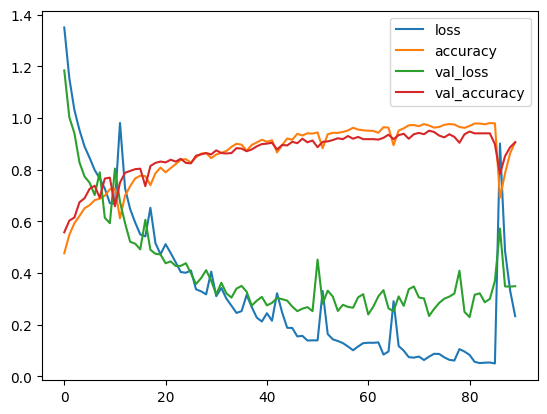

In [ ]:
Grap_Data = pd.DataFrame(Conv1D_Model.history)
figure = plt.figure(figsize=(10,10))
Grap_Data.plot()
plt.savefig('CNN_all_loss_accuracy.pdf', dpi=1)

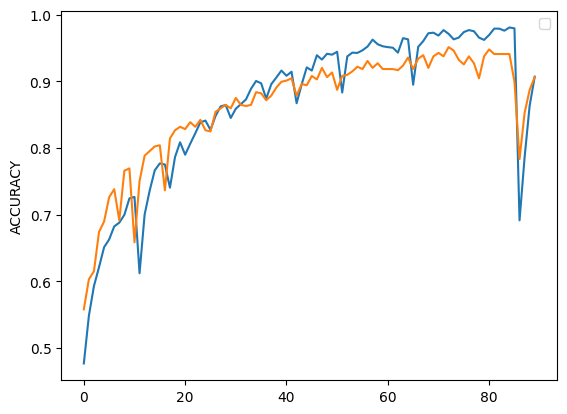

In [ ]:
plt.plot(Conv1D_Model.history["accuracy"])
plt.plot(Conv1D_Model.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.savefig('CNN_accuracy.pdf', dpi=1)
plt.show()


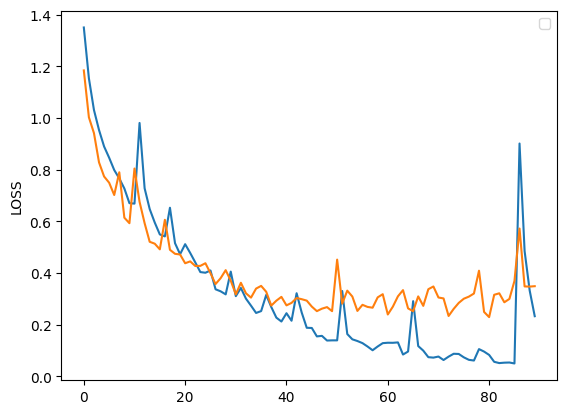

In [ ]:
plt.plot(Conv1D_Model.history["loss"])
plt.plot(Conv1D_Model.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.savefig('CNN_loss.pdf', dpi=1)
plt.show()


In [ ]:
Model_Results = Model.evaluate(xTest,yTest)
print("LOSS:  " + "%.4f" % Model_Results[0])
print("ACCURACY:  " + "%.4f" % Model_Results[1])

19/19 [==============================] - 0s 5ms/step - loss: 0.3494 - accuracy: 0.9064
LOSS:  0.3494
ACCURACY:  0.9064


In [ ]:
prediction_test = Model.predict(xTest)
y_prediction = encoder_label.inverse_transform(prediction_test)

yTest = encoder_label.inverse_transform(yTest)

19/19 [==============================] - 1s 8ms/step


In [ ]:
print(y_prediction[0:10])

[['normal']
 ['normal']
 ['extrastole']
 ['normal']
 ['normal']
 ['normal']
 ['normal']
 ['murmur']
 ['murmur']
 ['normal']]


In [ ]:
print(yTest[0:10])

[['normal']
 ['normal']
 ['normal']
 ['normal']
 ['extrastole']
 ['normal']
 ['normal']
 ['murmur']
 ['murmur']
 ['normal']]


In [ ]:
conf_matrix = confusion_matrix(yTest, y_prediction)

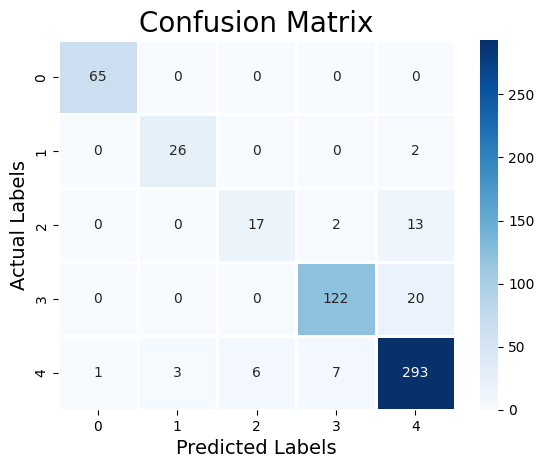

In [ ]:
sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('CNN_confusion_matrix.pdf', dpi=1)
plt.show()


In [ ]:
print(classification_report(yTest, y_prediction))

              precision    recall  f1-score   support

    artifact       0.98      1.00      0.99        65
    extrahls       0.90      0.93      0.91        28
  extrastole       0.74      0.53      0.62        32
      murmur       0.93      0.86      0.89       142
      normal       0.89      0.95      0.92       310

    accuracy                           0.91       577
   macro avg       0.89      0.85      0.87       577
weighted avg       0.90      0.91      0.90       577



# ANN MODEL

In [ ]:
X = New_Features_Wav.iloc[:,:-1].values
Y = New_Features_Wav["labels"].values
Y = encoder_label.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,train_size=0.8,random_state=42)

In [ ]:
y_train.shape

(2305, 5)

In [ ]:
X_train.shape

(2305, 288)

In [ ]:
# Construct model

# num_labels = Y.shape[1]
ANN_Model = Sequential()
ANN_Model.add(Dense(1000, activation="relu", input_shape=(X_train.shape[1],)))
ANN_Model.add(Dense(750, activation="relu"))
ANN_Model.add(Dense(500, activation="relu"))
ANN_Model.add(Dense(250, activation="relu"))
ANN_Model.add(Dense(100, activation="relu"))
ANN_Model.add(Dense(50, activation="relu"))
ANN_Model.add(Dense(5, activation="softmax"))
ANN_Model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 1000)              289000    
                                                                 
 dense_3 (Dense)             (None, 750)               750750    
                                                                 
 dense_4 (Dense)             (None, 500)               375500    
                                                                 
 dense_5 (Dense)             (None, 250)               125250    
                                                                 
 dense_6 (Dense)             (None, 100)               25100     
                                                                 
 dense_7 (Dense)             (None, 50)                5050      
                                                                 
 dense_8 (Dense)             (None, 5)                

In [ ]:
import time

ANN_Model.compile(
    optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
)

num_epochs = 90
num_batch_size = 64

t0 = time.time()

ANN_Results = ANN_Model.fit(
    X_train,
    y_train,
    batch_size=num_batch_size,
    epochs=num_epochs,
    validation_data=(X_test, y_test),
)

train_hist_m1 = pd.DataFrame(ANN_Results.history)
train_m1 = round(time.time() - t0, 3)


Epoch 1/90
37/37 [==============================] - 3s 10ms/step - loss: 70.5129 - accuracy: 0.4030 - val_loss: 34.0605 - val_accuracy: 0.5615
Epoch 2/90
37/37 [==============================] - 0s 7ms/step - loss: 16.8280 - accuracy: 0.4963 - val_loss: 6.4401 - val_accuracy: 0.6066
Epoch 3/90
37/37 [==============================] - 0s 8ms/step - loss: 2.7635 - accuracy: 0.5701 - val_loss: 3.5377 - val_accuracy: 0.6412
Epoch 4/90
37/37 [==============================] - 0s 9ms/step - loss: 2.1917 - accuracy: 0.5813 - val_loss: 3.6145 - val_accuracy: 0.5823
Epoch 5/90
37/37 [==============================] - 0s 8ms/step - loss: 2.6197 - accuracy: 0.6013 - val_loss: 6.5206 - val_accuracy: 0.3657
Epoch 6/90
37/37 [==============================] - 0s 8ms/step - loss: 2.3564 - accuracy: 0.5883 - val_loss: 1.1801 - val_accuracy: 0.6482
Epoch 7/90
37/37 [==============================] - 0s 9ms/step - loss: 1.0318 - accuracy: 0.6373 - val_loss: 1.0146 - val_accuracy: 0.6724
Epoch 8/90
37/37

<Figure size 1000x1000 with 0 Axes>

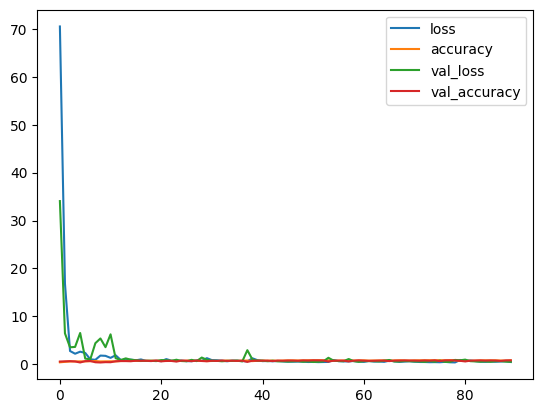

In [ ]:
train_hist_m1 = pd.DataFrame(ANN_Results.history)
train_m1 = round(time.time() - t0, 3)
figure = plt.figure(figsize=(10,10))
train_hist_m1.plot()
plt.savefig('ANN_all_loss_accuracy.pdf', dpi=1)

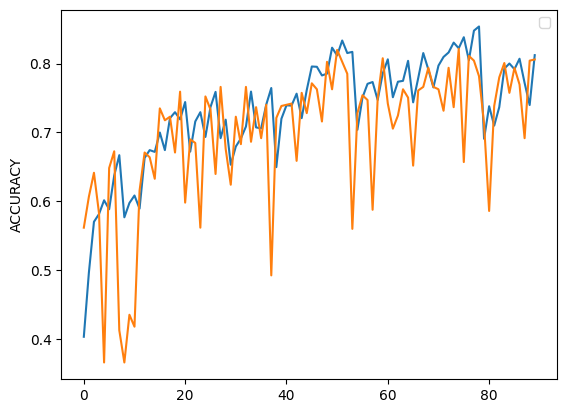

In [ ]:
plt.plot(ANN_Results.history["accuracy"])
plt.plot(ANN_Results.history["val_accuracy"])
plt.ylabel("ACCURACY")
plt.legend()
plt.savefig('ANN_accuracy.pdf', dpi=1)
plt.show()


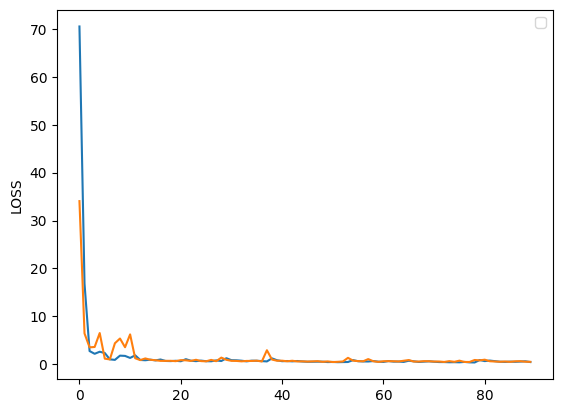

In [ ]:
plt.plot(ANN_Results.history["loss"])
plt.plot(ANN_Results.history["val_loss"])
plt.ylabel("LOSS")
plt.legend()
plt.savefig('ANN_loss.pdf', dpi=1)
plt.show()

In [ ]:
acc_m1 = ANN_Model.evaluate(X_test, y_test, verbose=0)
t0 = time.time()
y_pred_m1 = ANN_Model.predict(X_test, verbose=0)



In [ ]:
acc_m1

[0.5128580927848816, 0.8058925271034241]

In [ ]:
y_pred_m1.shape

(577, 5)

In [ ]:

y_prediction_ann = encoder_label.inverse_transform(y_pred_m1)

yTest_ann = encoder_label.inverse_transform(y_test)

In [ ]:
print(y_pred_m1[0:10])

[[1.28839712e-03 1.68730121e-03 1.09637536e-01 6.23693131e-02
  8.25017393e-01]
 [3.10933247e-04 3.10402625e-04 5.76067865e-02 1.59167856e-01
  7.82604039e-01]
 [9.40958969e-04 2.72175949e-03 1.03376433e-01 1.39128551e-01
  7.53832281e-01]
 [5.44580631e-04 3.93352332e-03 9.39794481e-02 5.95064610e-02
  8.42036009e-01]
 [4.96509929e-05 2.18269473e-04 7.41017833e-02 7.55976439e-02
  8.50032628e-01]
 [4.49908664e-03 2.44779093e-03 3.49398181e-02 8.18256363e-02
  8.76287639e-01]
 [1.33293626e-10 1.22061857e-11 3.27890652e-04 6.12362521e-04
  9.99059737e-01]
 [4.00529915e-10 5.46768100e-12 1.45380750e-06 9.99529600e-01
  4.68937826e-04]
 [2.99563077e-08 2.34937758e-09 2.77835710e-07 9.98435676e-01
  1.56409654e-03]
 [2.30518182e-07 6.08355094e-06 1.17793009e-02 8.81593022e-03
  9.79398370e-01]]


In [ ]:
print(y_prediction_ann[0:10])

[['normal']
 ['normal']
 ['normal']
 ['normal']
 ['normal']
 ['normal']
 ['normal']
 ['murmur']
 ['murmur']
 ['normal']]


In [ ]:
print(yTest_ann[0:10])

[['normal']
 ['normal']
 ['normal']
 ['normal']
 ['extrastole']
 ['normal']
 ['normal']
 ['murmur']
 ['murmur']
 ['normal']]


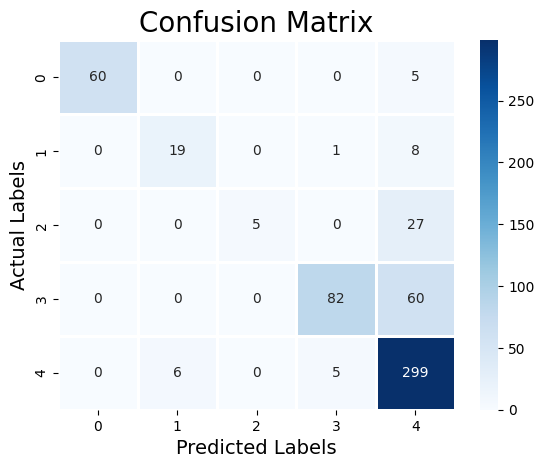

In [ ]:
conf_matrix = confusion_matrix(yTest_ann, y_prediction_ann)

sns.heatmap(conf_matrix, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')

plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.savefig('ANN_confusion_matrix.pdf', dpi=1)
plt.show()

In [ ]:
print(classification_report(yTest_ann, y_prediction_ann))

              precision    recall  f1-score   support

    artifact       1.00      0.92      0.96        65
    extrahls       0.76      0.68      0.72        28
  extrastole       1.00      0.16      0.27        32
      murmur       0.93      0.58      0.71       142
      normal       0.75      0.96      0.84       310

    accuracy                           0.81       577
   macro avg       0.89      0.66      0.70       577
weighted avg       0.84      0.81      0.79       577

